## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

/home/anushka/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
# Split data in to 95:5 for training: validation sets
train_set,validation_set=train_test_split(nltk_data,test_size=0.05,train_size=0.95,random_state = 101)

print(len(train_set))
print(len(validation_set))


3718
196


In [5]:
#Printing First few tagged sentences in training data set
print(train_set[1:5])

[[('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she', 'PRON'), ('did', 'VERB'), ('*T*-97', 'X'), ('was', 'VERB'), ('like', 'ADP'), ('*', 'X'), ('taking', 'VERB'), ('the', 'DET'), ('law', 'NOUN'), ('into', 'ADP'), ('your', 'PRON'), (

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95547

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12100


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'DET', 'VERB', 'ADP', 'NOUN', 'X', 'ADJ', 'CONJ', 'PRT', 'PRON', '.', 'ADV', 'NUM'}


### POS Tagging Algorithm - HMM


We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

#### Emission Probablities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities

In [13]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1]) # Count Number of times t1 has appeared
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2: # Number of times next index for t1 - next tag after t1 is t2
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)


In [14]:
# creating t x t transition matrix of tag
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
tags_matrix

array([[5.67564322e-03, 3.98502611e-02, 9.53991059e-03, 6.38087213e-01,
        4.54051457e-02, 2.04323143e-01, 4.83033451e-04, 2.41516726e-04,
        3.74350930e-03, 1.79929957e-02, 1.24381110e-02, 2.22195387e-02],
       [1.34391949e-01, 1.69248641e-01, 9.20216888e-02, 1.10069714e-01,
        2.17505813e-01, 6.49883822e-02, 5.57707204e-03, 3.06738969e-02,
        3.57862115e-02, 3.49341594e-02, 8.19519758e-02, 2.28505041e-02],
       [3.24708641e-01, 8.33956990e-03, 1.68929752e-02, 3.20966542e-01,
        3.44274566e-02, 1.07024483e-01, 9.62258084e-04, 1.38992839e-03,
        7.00310096e-02, 3.90249118e-02, 1.40062012e-02, 6.22260235e-02],
       [1.29423812e-02, 1.47667453e-01, 1.76513597e-01, 2.63563901e-01,
        2.91751977e-02, 1.22477328e-02, 4.26659845e-02, 4.33971919e-02,
        4.60661016e-03, 2.40603983e-01, 1.70737058e-02, 9.54226404e-03],
       [5.47422022e-02, 2.03851044e-01, 1.42584339e-01, 6.23806491e-02,
        7.63844699e-02, 1.71865057e-02, 1.06619988e-02, 1.85

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,DET,VERB,ADP,NOUN,X,ADJ,CONJ,PRT,PRON,.,ADV,NUM
DET,0.005676,0.039850,0.009540,0.638087,0.045405,0.204323,0.000483,0.000242,0.003744,0.017993,0.012438,0.022220
VERB,0.134392,0.169249,0.092022,0.110070,0.217506,0.064988,0.005577,0.030674,0.035786,0.034934,0.081952,0.022851
ADP,0.324709,0.008340,0.016893,0.320967,0.034427,0.107024,0.000962,0.001390,0.070031,0.039025,0.014006,0.062226
NOUN,0.012942,0.147667,0.176514,0.263564,0.029175,0.012248,0.042666,0.043397,0.004607,0.240604,0.017074,0.009542
X,0.054742,0.203851,0.142584,0.062381,0.076384,0.017187,0.010662,0.185232,0.055538,0.163590,0.024984,0.002864
ADJ,0.004943,0.011699,0.078267,0.699621,0.021091,0.066403,0.016971,0.010710,0.000330,0.063931,0.004778,0.021256
CONJ,0.121339,0.156671,0.052534,0.349140,0.008833,0.118085,0.000465,0.004649,0.058113,0.034868,0.055323,0.039981
PRT,0.097858,0.405272,0.020099,0.247776,0.013509,0.083031,0.002306,0.001647,0.017792,0.043822,0.010214,0.056672
PRON,0.009954,0.485452,0.022971,0.210949,0.089969,0.073124,0.005360,0.013017,0.007657,0.040965,0.034074,0.006508
.,0.173335,0.089095,0.091342,0.222242,0.026971,0.043963,0.057538,0.002427,0.066349,0.093320,0.052324,0.081003


##### Visualizing the DataFrame using Heat Map:

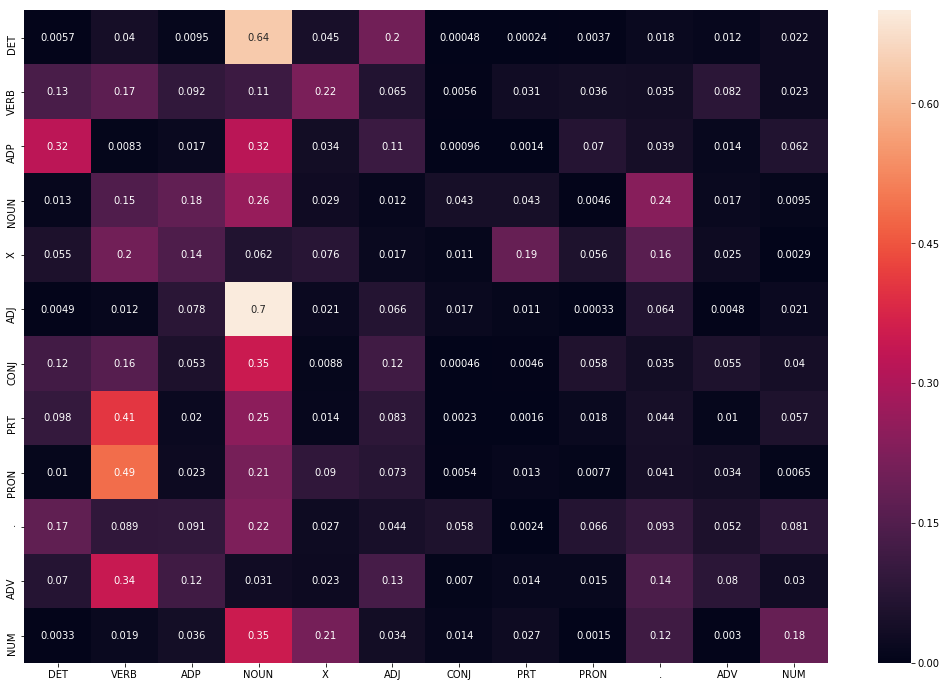

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [19]:
len(train_tagged_words)

95547

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating Unmodified Vanilla Viterbi POS


In [21]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(5)]

# list of sents
test_run = [validation_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  16.058733224868774


In [23]:

print(tagged_seq)
#print(test_run_base)

[('The', 'DET'), ('Contra', 'DET'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'DET'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'DET'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'DET'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'DET'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'DET'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'DET'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN'), ('s

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [25]:
original_viterbi_accuracy = len(check)/len(tagged_seq)

In [26]:
original_viterbi_accuracy

0.8938053097345132

##### Checking for incorrect tagged sentence

In [27]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [28]:
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', 'DET'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'DET'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'DET'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'DET'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'DET'), ('rebel', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', 'DET'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', 'DET'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', 'DET'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'DET'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', 'DET'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

### Solve the problem of unknown words

#### Viterbi Modification - Technique I 

There are 2 kinds of probabilities: Transition and Emission. So, if we find that emission probability is 0; it means, the word is unknown. So, according to this case, we'll use only transition probabilty otherwise we'll use both emission and transition probabilities.

In [29]:
def modified_viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # Now, modifying the original Vanilla Viterbi Algorithm to consider unknown words:
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [31]:
start = time.time()
tagged_seq1 = modified_viterbi_1(test_tagged_words)
end = time.time()
print("Time taken (in seconds): ", difference)

# accuracy
unknown_words = [i for i, j in zip(tagged_seq1, test_run_base) if i == j]

modified_viterbi_accuracy = len(unknown_words)/len(tagged_seq1)

print("Vanilla Viterbi Modified Accuracy: {}".format(modified_viterbi_accuracy))

Time taken (in seconds):  16.058733224868774
Vanilla Viterbi Modified Accuracy: 0.9469026548672567


In [32]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq1, test_run_base)) if j[0]!=j[1]]

In [33]:
incorrect_tagged_words

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'DET'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'VERB'), ('Sandinista', 'NOUN'))],
 [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'VERB'), ('*T*-252', 'X'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

#### Viterbi Modification -Technique  2 : Rule Based Tagger

In [34]:
# List containing tuples of POS tags and probability of its occurance
tag_prob = []
AllTags = len([tag for word,tag in train_tagged_words])
for t in T:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/AllTags))

tag_prob

[('DET', 0.08666938784053921),
 ('VERB', 0.1351167488251855),
 ('ADP', 0.0978889970381069),
 ('NOUN', 0.2862674913916711),
 ('X', 0.06576867928872701),
 ('ADJ', 0.06351847781719991),
 ('CONJ', 0.02251248076862696),
 ('PRT', 0.03176447193527793),
 ('PRON', 0.0273373313657153),
 ('.', 0.11641391147812072),
 ('ADV', 0.031597015081582885),
 ('NUM', 0.035145007169246546)]

In [35]:
# Defining Regular Expression rules (regex) for tagging
patterns = [
        (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

RegEx_Rule_Based_Tagger = nltk.RegexpTagger(patterns)

In [36]:
# Viterbi Modification - Rule Based Tagger
def Viterbi_Technique2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))  
    for key, word in enumerate(words):
        p = [] #list of probability column 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag] # Taking dot '.' as the previous tag
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)

            # Finding Occurance probability of POS Tag
            Occurance_tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]

            # calculate the transition prob weighted by tag occurance probability.
            transition_p = Occurance_tag_p[0]*transition_p 
            p_transition.append(transition_p)        
        
        pmax = max(p)
        state_max = RegEx_Rule_Based_Tagger.tag([word])[0][1]
        
        # Taking state - Probability Maximum
        if(pmax==0):
            state_max = RegEx_Rule_Based_Tagger.tag([word])[0][1] # assign based on rule based tagger
        
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [37]:
start = time.time()
tagged_seq = Viterbi_Technique2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,1))


Time taken in seconds:  16.9


In [38]:
print(tagged_seq)

[('The', 'DET'), ('Contra', 'NOUN'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'NOUN'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'NOUN'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'VERB'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interest', 'NOUN'), ('.', '.'), ('Ralston', 'NOUN

In [39]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [40]:
# Calculate Accuracy
rule_based_viterbi_accuracy = len(check)/len(tagged_seq)

In [41]:
print("Accuracy of Viterbi Modification 1 :", round(rule_based_viterbi_accuracy*100,2))

Accuracy of Viterbi Modification 1 : 98.23


In [42]:
# Taking set of all pairs where the tag that is assigned by us is not same as the tag assigned in the dataset
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [43]:
incorrect_tagged_words

[[('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [44]:
acccuracy = [['Vanilla Viterbi Original', original_viterbi_accuracy*100], 
                  ['Vanilla Viterbi Modified', modified_viterbi_accuracy * 100], 
                  ['Rule Based Viterbi', rule_based_viterbi_accuracy * 100]]
acccuracy_df = pd.DataFrame(acccuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_df.sort_values(by='Tagging_Accuracy', ascending= False)

,Tagging_Accuracy
Tagging_Algorithm,
Rule Based Viterbi,98.230088
Vanilla Viterbi Modified,94.690265
Vanilla Viterbi Original,89.380531


#### Evaluation on the given 'Test_sentences.txt' file¶


In [45]:
# Opening text file
OpenTextFile=open('Test_sentences.txt')

# Reading text file
SampleSentences = OpenTextFile.read()

In [46]:
sample_test_sentences = SampleSentences.splitlines()
sample_test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [47]:
print(sample_test_sentences)

['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to experience the laun

In [48]:
# list of words
Words_Test = [words for sentences in sample_test_sentences for words in sentences.split()]

In [49]:
print(Words_Test)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', "Twitter's", 'firehose.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets.', 'Before', 'entering', 'politics,', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup,', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and', 'the', '11th', 'time', 'that', 'it'

#### Evaluation on the entire 'Test_sentences.txt' file - Unmodified Vanilla Viterbi POS tagger


In [50]:
# Tagging the test sentences - Calling Viterbi Vanilla function
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq = Viterbi(Words_Test)
end = time.time()
difference = end-start

print("Unmodified Vanilla Viterbi POS tagger - Time taken in seconds: ", round(difference,1))

Unmodified Vanilla Viterbi POS tagger - Time taken in seconds:  27.4


In [51]:
print(tagged_seq)

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'DET'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'DET'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'DET'), ('firehose.', 'DET'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('inte

#### Evaluation on the entire 'Test_sentences.txt' file - Modified Vanilla Viterbi -Technique 1

In [52]:
# Tagging the test sentences
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq_ = modified_viterbi_1(Words_Test)
end = time.time()
difference = end-start

print("Unmodified Vanilla Viterbi POS tagger - Time taken in seconds: ", round(difference,1))

Unmodified Vanilla Viterbi POS tagger - Time taken in seconds:  24.3


In [53]:
print(tagged_seq_)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'DET'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'DET'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'VERB'), ('firehose.', 'X'), ('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), (

#### Evaluation on the entire 'Test_sentences.txt' file - Modified Vanilla Viterbi -Technique 2

In [54]:
# Tagging the test sentences
# Using start time and end time to measure the timetaken
start = time.time()
tagged_seq2 = Viterbi_Technique2(Words_Test)
end = time.time()
difference = end-start

print("Unmodified Vanilla Viterbi POS tagger - Time taken in seconds: ", round(difference,1))

Unmodified Vanilla Viterbi POS tagger - Time taken in seconds:  28.9


In [55]:
print(tagged_seq2)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', '

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [56]:
tags_df = pd.DataFrame(columns = ['Original_Tags', 'Vanilla_Viterbi_Tags', 'Modified_Vanilla_Viterbi_Tags',
            'Vanilla_Viterbi_Tags_Backed_By_Rule Based'])
tags_df = tags_df.fillna(0)

In [57]:
# Original tags
tags_df['Original_Tags'] = [x for x in Words_Test]

# tags by vanilla viterbi
tags_df['Vanilla_Viterbi_Tags'] = [x for x in tagged_seq]

# tags by Modified Viterbi - Technique - 1
tags_df['Modified_Vanilla_Viterbi_Tags'] = [x for x in tagged_seq_]

# tags by viterbi_backedup_by_Rule Based - Technique - 2
tags_df['Vanilla_Viterbi_Tags_Backed_By_Rule Based'] = [x for x in tagged_seq2]

tags_df[tags_df['Vanilla_Viterbi_Tags'] != tags_df['Vanilla_Viterbi_Tags_Backed_By_Rule Based']]

,Original_Tags,Vanilla_Viterbi_Tags,Modified_Vanilla_Viterbi_Tags,Vanilla_Viterbi_Tags_Backed_By_Rule Based
0,Android,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
8,Google.,"(Google., DET)","(Google., DET)","(Google., NOUN)"
9,Android,"(Android, DET)","(Android, NOUN)","(Android, NOUN)"
14,OS,"(OS, DET)","(OS, NOUN)","(OS, NOUN)"
15,worldwide,"(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
17,smartphones,"(smartphones, DET)","(smartphones, DET)","(smartphones, VERB)"
19,2011,"(2011, DET)","(2011, DET)","(2011, NUM)"
24,2013.,"(2013., DET)","(2013., DET)","(2013., NOUN)"
25,Google,"(Google, DET)","(Google, NOUN)","(Google, NOUN)"
27,Twitter,"(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"
